In [1]:
# Import what we need for the script.

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from EqW import *

In [2]:
# Create a function which generates a gaussian.

def gaussian(x, mu, sig, pwr):
    return pwr * (np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.))))

In [3]:
# Define a continuum fit function.

def region_around_line(w, flux, cont, pf = 0):
    '''cut out and normalize flux around a line

    Parameters
    ----------
    w : 1 dim np.ndarray
        array of wanvelenghts
    flux : np.ndarray of shape (N, len(w))
        array of flux values for different spectra in the series
    cont : list of lists
        wavelengths for continuum normalization [[low1,up1],[low2, up2]]
        that described two areas on both sides of the line
    '''
    #index is true in the region where we fit the polynomial
    indcont = ((w > cont[0][0]) & (w < cont[0][1])) |((w > cont[1][0]) & (w < cont[1][1]))
    #index of the region we want to return
    indrange = (w > cont[0][0]) & (w < cont[1][1])
    fluxmean = np.mean(flux[:,np.where(indcont)])
    # make a flux array of shape
    # (nuber of spectra, number of pointsin indrange)
    f = np.zeros((flux.shape[0], indrange.sum()))
    for i in range(flux.shape[0]):
        # fit polynom of second order to the continuum region
        linecoeff = np.polyfit(w[indcont], flux[i, indcont], pf)
        # devide the flux by the polynom and put the result in our
        # new flux array
        f[i,:] = flux[i,indrange]/np.polyval(linecoeff, w[indrange])
    if fluxmean < 0:
        f = -f
    return w[indrange], f

In [4]:
# Define error functions for the optimisation of the gaussian fit. Penalise fits far from the Ha line using regularisation (check if this is appropriate).

def error(data, flux, wavelength):
    mu, sig, pwr = data
    if sig < 1.8 or sig > 25:
        return np.inf
    fit = gaussian(wavelength, mu, sig, pwr)
    return np.sum(np.power(flux - fit, 2.)) + 0.01 * np.power(mu - 5876, 2.)

def error2(data, flux, wavelength):
    mu, sig, pwr = data
    if sig < 1.8 or sig > 25:
        return np.inf
    fit = gaussian(wavelength, mu, sig, pwr)
    return np.power(flux - fit, 2.)

In [5]:
# Import the scipy.optimize.minimize function

from scipy.optimize import minimize

In [6]:
# Import SpectRes package to rebin the gaussian into the spectrum wavelength bins whilst conserving flux.

from spectres import spectres

In [7]:
# Define a new error function using SpectRes for the optimisation.

def reerr(data, w, f, gauw):
    mu, sig, pwr = data
    if sig < 1.8 or sig > 25:
        return np.inf
    res_fluxes = spectres(w, gauw, gaussian(gauw, mu, sig, pwr))
    return np.sum(np.power(f - res_fluxes, 2.)) + 0.1 * np.power(mu - 5876, 2.)

In [8]:
def halinefit(file, rang, quiet = False, cfit = 0):
    
    flux = np.load(file)
    wavelength = np.load('wavelength.npy')
    
    wha, fha = region_around_line(wavelength, np.reshape(flux, (1, np.size(flux))), rang, pf = cfit)
    fha = np.reshape(fha, np.size(wha))
    
    if not quiet:
        plt.plot(wavelength, flux)
        plt.xlim((rang[0][0]-10,rang[1][1]+10))
        plt.ylim((-0.4e-17,0.2e-17))
        plt.show()
    
    x0 = np.array((5876, 10, -5))
    gauw = np.linspace(rang[0][0]-10, rang[1][1]+10, 1000)
    res = minimize(reerr, x0, args=(wha, fha, gauw), method='Nelder-Mead', tol=1e-6)
    
    if not quiet:
        plt.plot(wha, fha)
        plt.plot(gauw, gaussian(gauw, res.x[0], res.x[1], res.x[2]))
    
    res_spec = spectres(wha, gauw, gaussian(gauw, res.x[0], res.x[1], res.x[2]))
    
    if not quiet:
        plt.show()
    
    cont = fha - res_spec
    
    if not quiet:
        plt.plot(wha, cont)
        plt.show()
    
    ew = (np.sum(gaussian(gauw, res.x[0], res.x[1], res.x[2]))/res.x[2])*(gauw[1]-gauw[0])
    
    snr = np.abs(res.x[2]) / np.std(cont)
    
    if not quiet:
        print(res.x)
    
        print(np.std(cont))
    
        print(snr)
        
    quans = np.quantile(cont, [0.05, 0.95])
    
    return ew, snr, quans[0], quans[1]
    

In [9]:
rang = [[5750, 5800],[5900, 5950]]

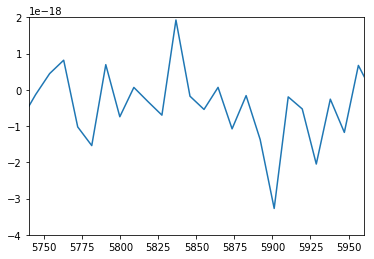

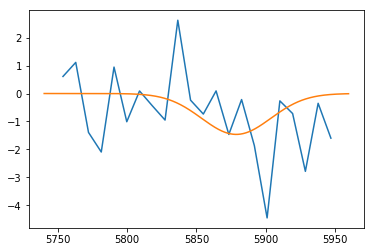

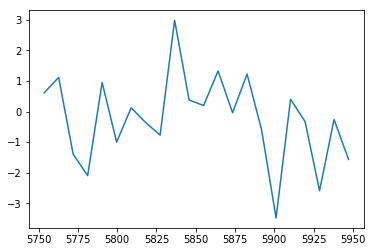

[ 5.87881730e+03  2.50000000e+01 -1.46414925e+00]
1.406654029187248
1.0408737493935298


(62.62976477712373, 1.0408737493935298, -2.5606973572816223, 1.318937385507708)

In [10]:
halinefit('blap09_group1_mean_subtracted.npy', rang)

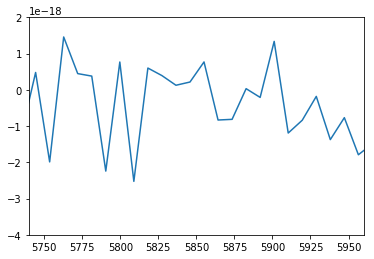

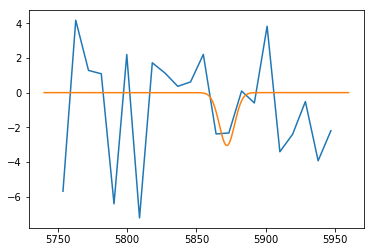

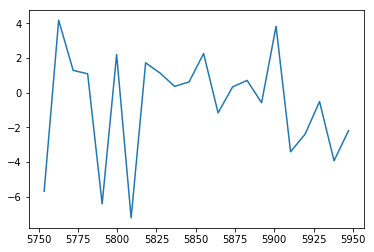

[ 5.87209676e+03  5.48834945e+00 -3.05091075e+00]
3.0670158313769647
0.994748940519887


(13.757251915772438,
 0.994748940519887,
 -6.3813781113118475,
 3.7486921400855326)

In [11]:
halinefit('blap09_group2_mean_subtracted.npy', rang)

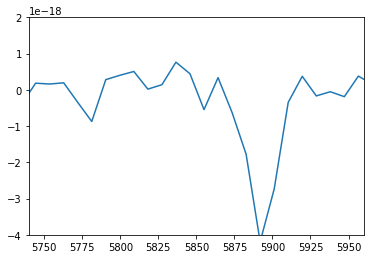

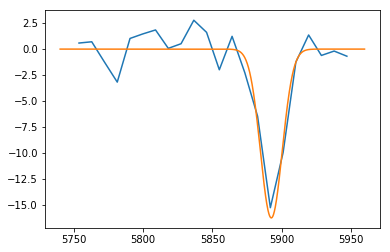

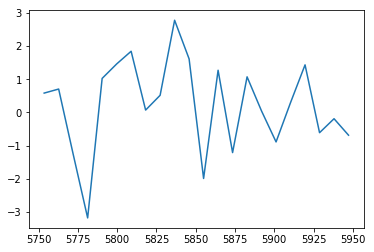

[5892.61629986    7.8471429   -16.24366976]
1.3589317898925732
11.953263496943947


(19.669870278494564,
 11.953263496943947,
 -1.951295776146017,
 1.8308345911698762)

In [12]:
halinefit('blap09_group3_mean_subtracted.npy', rang)

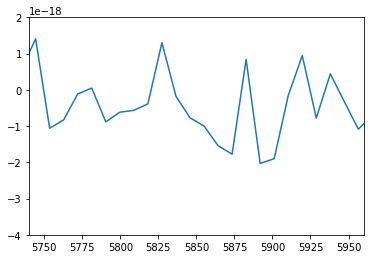

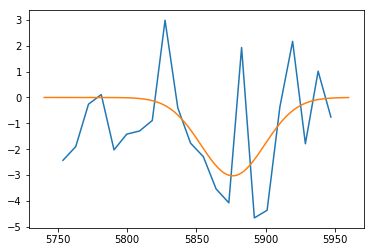

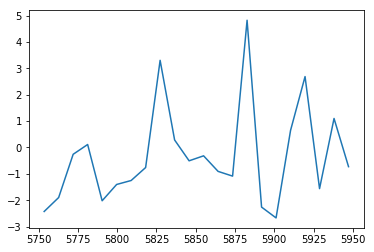

[ 5.87630481e+03  2.29570643e+01 -3.02545212e+00]
1.8597408807336873
1.6268137974086894


(57.53729686619573,
 1.6268137974086894,
 -2.4185143415852375,
 3.2704228099823696)

In [13]:
halinefit('blap09_group4_mean_subtracted.npy', rang)

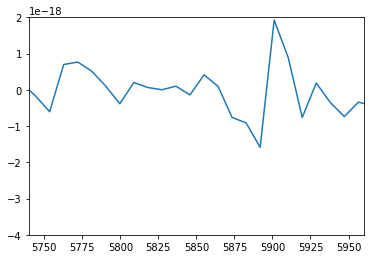

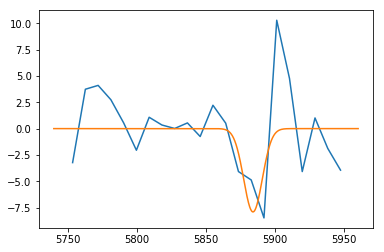

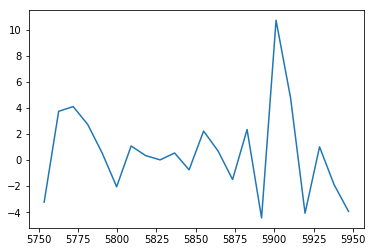

[5883.97797885    6.72832859   -7.90135746]
3.402938730230195
2.3219217524324325


(16.865418684440577, 2.3219217524324325, -4.068334476961606, 4.736102099995557)

In [14]:
halinefit('blap14_group1_mean_subtracted.npy', rang)

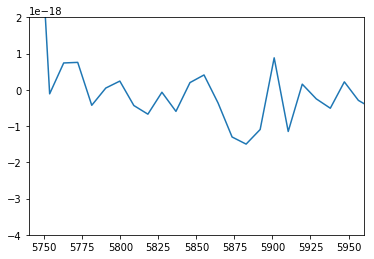

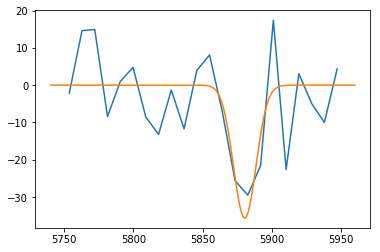

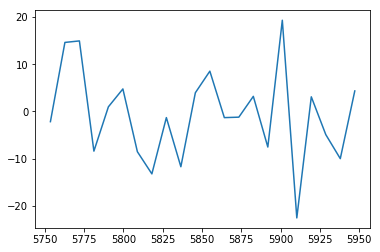

[5880.45755284    8.20326139  -35.61038031]
9.780692841179839
3.6408852505155354


(20.562526936736898,
 3.6408852505155354,
 -13.153656273397837,
 14.91676437650957)

In [15]:
halinefit('blap14_group3_mean_subtracted.npy', rang)

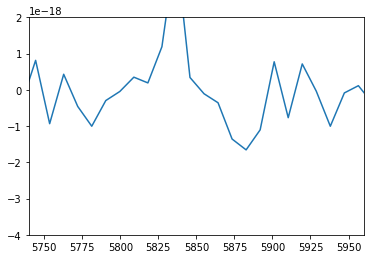

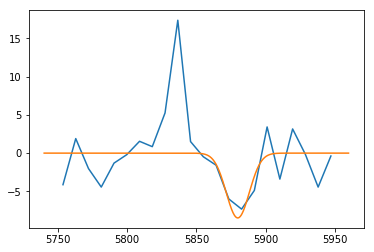

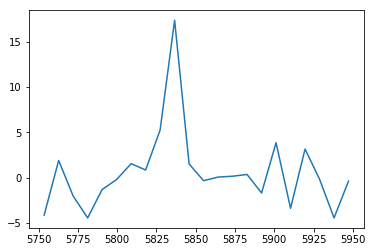

[5879.93856285    8.36591442   -8.4782138 ]
4.433967797103483
1.9121054065692962


(20.970237630167787, 1.9121054065692962, -4.425855780066439, 5.191846557082038)

In [16]:
halinefit('blap14_group4_mean_subtracted.npy', rang)